In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

stock_df = pd.read_csv('indexData.csv')
stock_df

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0
...,...,...,...,...,...,...,...,...
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0


In [2]:
stock_dfn = stock_df[stock_df['Index'] == 'NYA'].dropna()

In [3]:
stock_dfn['Date'] = pd.to_datetime(stock_dfn['Date'])

In [4]:
stock_dfn['day_difference'] = stock_dfn['Date'].diff().dt.days

In [5]:
data = stock_dfn['Adj Close']
data

0          528.690002
1          527.210022
2          527.840027
3          531.119995
4          532.070007
             ...     
13943    16464.689450
13944    16390.189450
13945    16451.960940
13946    16531.949220
13947    16555.660160
Name: Adj Close, Length: 13947, dtype: float64

In [6]:
dates = stock_dfn['Date']
dates

0       1965-12-31
1       1966-01-03
2       1966-01-04
3       1966-01-05
4       1966-01-06
           ...    
13943   2021-05-24
13944   2021-05-25
13945   2021-05-26
13946   2021-05-27
13947   2021-05-28
Name: Date, Length: 13947, dtype: datetime64[ns]

In [7]:
data.shape

(13947,)

In [8]:
data = np.reshape(data, (len(data), 1))
data.shape

(13947, 1)

In [9]:
data

array([[  528.690002],
       [  527.210022],
       [  527.840027],
       ...,
       [16451.96094 ],
       [16531.94922 ],
       [16555.66016 ]])

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.01113857],
       [0.01104745],
       [0.01108624],
       ...,
       [0.991475  ],
       [0.99639958],
       [0.99785937]])

In [11]:
window_size = 10

X, y = [], []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X[:2]

array([[0.01113857, 0.01104745, 0.01108624, 0.01128818, 0.01134666,
        0.01137929, 0.01145748, 0.01148334, 0.01142486, 0.01149012],
       [0.01104745, 0.01108624, 0.01128818, 0.01134666, 0.01137929,
        0.01145748, 0.01148334, 0.01142486, 0.01149012, 0.01155476]])

In [12]:
X.shape

(13937, 10)

In [13]:
train_split = 0.8
validation_split = 0.1
test_split = 0.1

train_split_index = int(len(scaled_data) * train_split)
validation_split_index = int(len(scaled_data) * (train_split + validation_split))

X_train = X[:train_split_index]
Y_train = y[:train_split_index]
X_validation = X[train_split_index:validation_split_index]
Y_validation = y[train_split_index:validation_split_index]
X_test = X[validation_split_index:]
Y_test = y[validation_split_index:]

print("Rozmiar zbioru treningowego:", len(X_train))
print("Rozmiar zbioru walidacyjnego:", len(X_validation))
print("Rozmiar zbioru testowego:", len(X_test))

Rozmiar zbioru treningowego: 11157
Rozmiar zbioru walidacyjnego: 1395
Rozmiar zbioru testowego: 1385


In [14]:
dates = dates[window_size:]
print(len(dates))

13937


In [15]:
X_train[:2]

array([[0.01113857, 0.01104745, 0.01108624, 0.01128818, 0.01134666,
        0.01137929, 0.01145748, 0.01148334, 0.01142486, 0.01149012],
       [0.01104745, 0.01108624, 0.01128818, 0.01134666, 0.01137929,
        0.01145748, 0.01148334, 0.01142486, 0.01149012, 0.01155476]])

In [16]:
model_gru = tf.keras.models.Sequential()
model_gru.add(tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.GRU(units=50))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(units=20, activation='tanh'))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(units=1))


model_gru.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])
model_gru.summary()

history_gru = model_gru.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=0.2)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [17]:
model_gru.evaluate(X_test, Y_test)

44/44 [==============================] - 0s 6ms/step - loss: 4.0211e-04 - mae: 0.0174


[0.0004021105414722115, 0.017415344715118408]

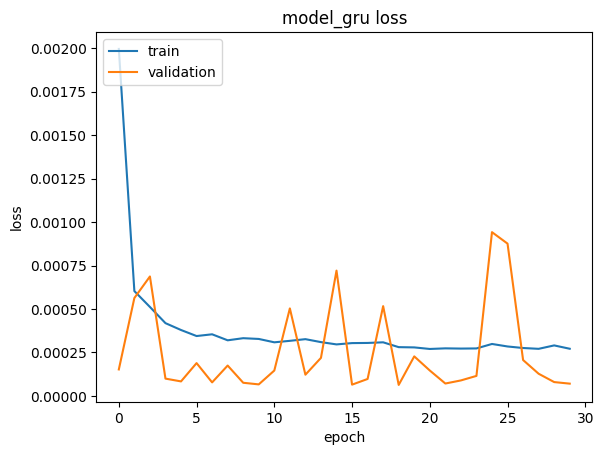

In [76]:
import matplotlib.pyplot as plt
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model_gru loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 33ms/step


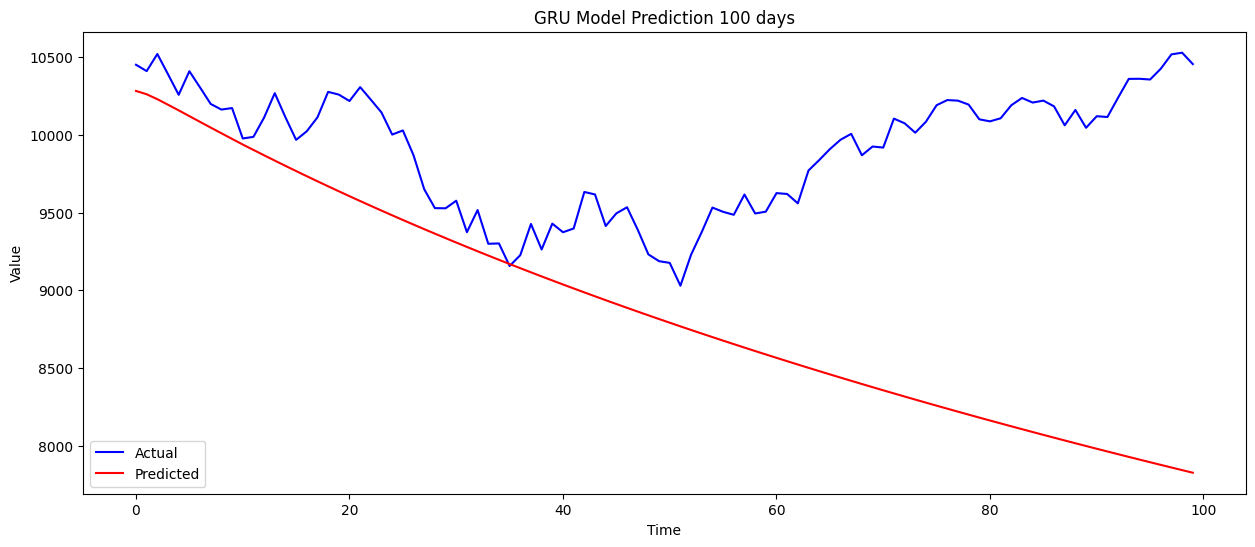

In [77]:
predictions = []
num_predictions = 100

current_window = X_test[0].reshape(1, -1, 1)

for i in range(num_predictions):
    predict_val = model_gru.predict(current_window)
    predictions.append(predict_val[0, 0])
    current_window = np.concatenate((current_window[:, 1:, :], predict_val.reshape(1, 1, 1)), axis=1)

y_test_actual = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
predictions_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:num_predictions], label='Actual', color='blue')
plt.plot(predictions_actual, label='Predicted', color='red')
plt.title('GRU Model Prediction 100 days')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

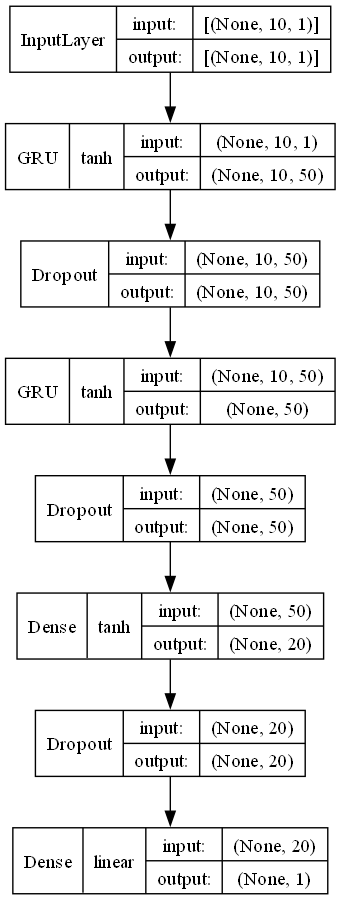

In [25]:
tf.keras.utils.plot_model(model_gru, show_layer_names=False, show_shapes=True, dpi=100,
                          show_layer_activations=True, to_file = 'model_GRU.png')